In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.preprocessing import OneHotEncoder, StandardScaler, QuantileTransformer, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, IsolationForest
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,roc_curve,confusion_matrix,mean_absolute_error,mean_squared_error,r2_score,make_scorer)
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def remplace_nan(df, column, strategy='most_frequent'):
    enc = SimpleImputer(strategy=strategy, fill_value=None)
    df[column] = enc.fit_transform(df[[column]]).ravel()
    return df


def Ajout_col_scaled(df, column):
    enc = StandardScaler()
    df[f"{column}_scaled"] = enc.fit_transform(df[[column]]).ravel()
    return df


def numeriser_feature(df, column):
    enc = LabelEncoder()
    cible = f"{column}_encoded"
    df[cible] = enc.fit_transform(df[column])
    return df


def one_hot_encode_feature(df, column):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded = encoder.fit_transform(df[[column]])
    feature_names = encoder.get_feature_names_out([column])
    encoded_df = pd.DataFrame(encoded, columns=feature_names, index=df.index).astype(int)
    df = pd.concat([df.drop(columns=[column]), encoded_df], axis=1)
    return df


def decouper_col(df, column, new_columns, true_token='V', delimiter='/'):
    def parser(value):
        if pd.isna(value) or value == "":
            return [None] * len(new_columns)
        tokens = str(value).split(delimiter)
        padded = (tokens + [''] * len(new_columns))[:len(new_columns)]
        return [1 if token == true_token else 0 if token else None for token in padded]

    df[new_columns] = df[column].apply(lambda val: pd.Series(parser(val), index=new_columns))
    return df


def normalize_with_kde(df, column):
  
    values = df[column].dropna()
    if values.empty:
        return df

    kde = gaussian_kde(values)
    grid = np.linspace(values.min(), values.max(), 1000)
    peaks = find_peaks(kde(grid), height=0.01, distance=50)[0]
    peak_positions = np.sort(grid[peaks])
    bounds = [values.min()]
    for left, right in zip(peak_positions[:-1], peak_positions[1:]):
        bounds.append((left + right) / 2)
    bounds.append(values.max())

    group_col = f"{column}_group"
    norm_col = f"{column}_normalise"
    df[group_col] = 0
    df[norm_col] = 0.0

    for idx, (start, end) in enumerate(zip(bounds[:-1], bounds[1:])):
        mask = (df[column] >= start) & (df[column] < end)
        segment = df.loc[mask, column]
        df.loc[mask, group_col] = idx
        if segment.notna().sum() > 10:
            skew = segment.skew()
            if abs(skew) < 0.5:
                transformer = StandardScaler()
            else:
                transformer = QuantileTransformer(
                    output_distribution='normal',
                    n_quantiles=min(100, segment.notna().sum())
                )
            df.loc[mask, norm_col] = transformer.fit_transform(segment.to_frame()).ravel()

    ordered_cols = [norm_col, group_col] + [c for c in df.columns if c not in [norm_col, group_col]]
    return df.loc[:, ordered_cols]


def standardise_window(value):
    
    mapping = {'without': 0, '>=10': 10, '10+': 10, '10': 10}
    token = str(value).strip().lower()
    if token in mapping:
        return mapping[token]
    try:
        return int(token)
    except ValueError:
        return 0
    if value in [">=10", "10+", "10"]:
        return 10
    return int(value)


def geo_code_cluster(code):
    if pd.isna(code):
        return "unknown"
    bins = [
        (10, "1 chiffre (0-9)", None),
        (100, "2 chiffres (10-99)", None),
        (1000, "3 chiffres", 100),
        (10000, "4 chiffres", 1000),
        (100000, "5 chiffres", 10000),
        (1000000, "6 chiffres", 100000)
    ]
    for upper, label, step in bins:
        if code < upper:
            if step is None:
                return label
            start = (code // step) * step
            end = start + step - 1
            return f"{label} ({start}-{end})"
    return "Plus de 6 chiffres"


def create_and_encode_geo_code(df, geo_col="Geo_Code"):
    df[geo_col] = df[geo_col].fillna("unknown")
    numeric_geo = pd.to_numeric(df[geo_col].replace("unknown", np.nan), errors="coerce")

    df["Geo_Cluster"] = numeric_geo.apply(geo_code_cluster)
    df.loc[df[geo_col] == "unknown", "Geo_Cluster"] = "unknown"
    df = one_hot_encode_feature(df, "Geo_Cluster")
    return df

## Chargement du dataset

In [3]:
test_df = pd.read_excel('insurance.xlsx', sheet_name='test')
print(f'Test: {test_df.shape}')
display(test_df.head())

Test: (2147, 13)


,policy_id,year,coverage_period,is_residential,is_finished_and_fenced,has_garden,locality,area_m2,structure_type,window_count,risk_score,Geo_Code,claim
0,H3733,2013,1.0,0,V/V,V,U,3760.0,Fire-resistive,without,0.72,43157,oui
1,H16909,2015,1.0,0,V/N,O,R,1452.0,Fire-resistive,5,0.45,58194,non
2,H16867,2013,1.0,1,V/N,O,R,1944.0,Ordinary,6,0.79,92050,oui
3,H14813,2015,1.0,0,N/V,V,U,2270.0,Non-combustible,without,0.66,13209,oui
4,H3728,2016,0.5,0,V/N,O,R,2976.0,Fire-resistive,9,0.18,5177,non


In [4]:
train_df = pd.read_excel('insurance.xlsx', sheet_name='train')
print(f"Dimension initiale du train: {train_df.shape}")
display(train_df.head())

Dimension initiale du train: (5014, 13)


,policy_id,year,coverage_period,is_residential,is_finished_and_fenced,has_garden,locality,area_m2,structure_type,window_count,risk_score,Geo_Code,claim
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H13501,2012.0,1.0,1.0,N/V,V,U,1240.0,Wood-framed,without,NaN,75117,non
3,H14962,2012.0,1.0,0.0,N/V,V,U,900.0,Non-combustible,without,NaN,62916,non
4,H17755,2013.0,1.0,1.0,V/N,O,R,4984.0,Non-combustible,4,NaN,31149,oui


In [5]:
print('Type dobjet:', type(train_df))
display(train_df.describe(include='all').transpose().head(10))
print('\nTop des colonnes avec valeurs manquantes:')
display(train_df.isnull().sum().sort_values(ascending=False).head(10))
print('\nInfos complètes:')
train_df.info()

Type dobjet: <class 'pandas.core.frame.DataFrame'>


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
policy_id,5012,5012,H18228,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,5012.0,NaN,NaN,NaN,2013.660215,1.383134,2012.0,2012.0,2013.0,2015.0,2016.0
coverage_period,5012.0,NaN,NaN,NaN,0.869713,0.219496,0.5,0.5,1.0,1.0,1.0
is_residential,5012.0,NaN,NaN,NaN,0.301077,0.458772,0.0,0.0,0.0,1.0,1.0
is_finished_and_fenced,5012,4,V/N,2530,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_garden,5008,2,O,2532,NaN,NaN,NaN,NaN,NaN,NaN,NaN
locality,5012,2,R,2537,NaN,NaN,NaN,NaN,NaN,NaN,NaN
area_m2,4935.0,NaN,NaN,NaN,1876.898683,2267.277397,1.0,520.0,1067.0,2280.0,20840.0
structure_type,5012,4,Non-combustible,2310,NaN,NaN,NaN,NaN,NaN,NaN,NaN
window_count,5012,11,without,2476,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Top des colonnes avec valeurs manquantes:


risk_score                5014
area_m2                     79
Geo_Code                    75
has_garden                   6
policy_id                    2
is_finished_and_fenced       2
is_residential               2
coverage_period              2
year                         2
structure_type               2
dtype: int64


Infos complètes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5014 entries, 0 to 5013
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   policy_id               5012 non-null   object 
 1   year                    5012 non-null   float64
 2   coverage_period         5012 non-null   float64
 3   is_residential          5012 non-null   float64
 4   is_finished_and_fenced  5012 non-null   object 
 5   has_garden              5008 non-null   object 
 6   locality                5012 non-null   object 
 7   area_m2                 4935 non-null   float64
 8   structure_type          5012 non-null   object 
 9   window_count            5012 non-null   object 
 10  risk_score              0 non-null      float64
 11  Geo_Code                4939 non-null   object 
 12  claim                   5012 non-null   object 
dtypes: float64(5), object(8)
memory usage: 509.4+ KB


### Visualisations 


C:\Users\MSI\AppData\Local\Temp\ipykernel_9164\1545002477.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='claim', data=train_df, ax=axes[1, 1], palette='pastel')


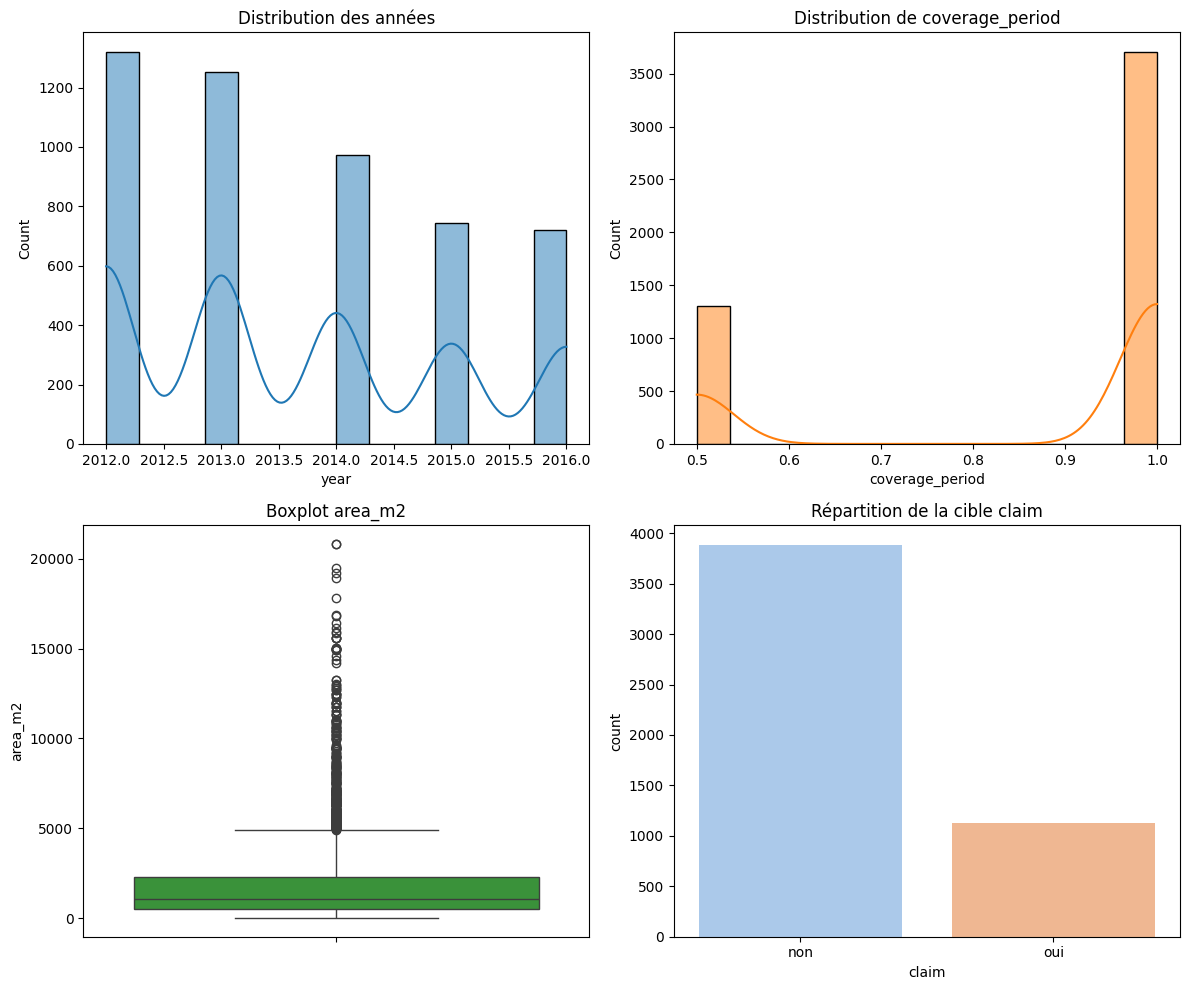

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.histplot(train_df['year'], kde=True, ax=axes[0, 0], color='#1f77b4')
axes[0, 0].set_title('Distribution des années')
sns.histplot(train_df['coverage_period'], kde=True, ax=axes[0, 1], color='#ff7f0e')
axes[0, 1].set_title('Distribution de coverage_period')
sns.boxplot(y=train_df['area_m2'], ax=axes[1, 0], color='#2ca02c')
axes[1, 0].set_title('Boxplot area_m2')
sns.countplot(x='claim', data=train_df, ax=axes[1, 1], palette='pastel')
axes[1, 1].set_title('Répartition de la cible claim')
plt.tight_layout()
plt.show()

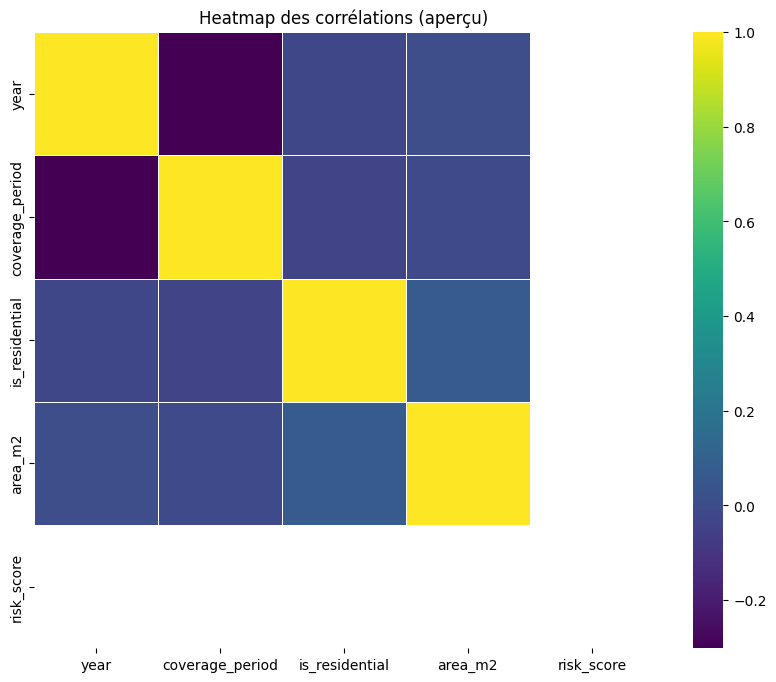

In [7]:
numeric_preview = train_df.select_dtypes(include=['int64', 'float64']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_preview, cmap='viridis', linewidths=0.5)
plt.title('Heatmap des corrélations (aperçu)')
plt.show()

## Nettoyage 

In [8]:
initial_rows = len(train_df)
train_df = train_df.dropna(how='all').copy()
train_df = train_df.reset_index(drop=True)
print(f'Lignes vides supprimées: {initial_rows - len(train_df)}')
display(train_df.head())

Lignes vides supprimées: 2


,policy_id,year,coverage_period,is_residential,is_finished_and_fenced,has_garden,locality,area_m2,structure_type,window_count,risk_score,Geo_Code,claim
0,H13501,2012.0,1.0,1.0,N/V,V,U,1240.0,Wood-framed,without,NaN,75117,non
1,H14962,2012.0,1.0,0.0,N/V,V,U,900.0,Non-combustible,without,NaN,62916,non
2,H17755,2013.0,1.0,1.0,V/N,O,R,4984.0,Non-combustible,4,NaN,31149,oui
3,H13369,2016.0,0.5,0.0,N/V,V,U,600.0,Wood-framed,without,NaN,6012,oui
4,H12988,2012.0,1.0,0.0,N/V,V,U,900.0,Non-combustible,without,NaN,57631,non


## Colonnes retirées 

In [9]:
cols_to_drop = ['risk_score', 'policy_id']
train_df = train_df.drop(columns=cols_to_drop)
print(f'Colonnes supprimées: {cols_to_drop}')

Colonnes supprimées: ['risk_score', 'policy_id']


## Year

In [10]:
train_df = normalize_with_kde(train_df, 'year')
display(train_df[['year_normalise', 'year_group']].head())

,year_normalise,year_group
0,-0.973902,0
1,-0.973902,0
2,1.026797,0
3,0.000000,0
4,-0.973902,0


## coverage_period

In [11]:
train_df = remplace_nan(train_df, 'coverage_period', strategy='median')
train_df = Ajout_col_scaled(train_df, 'coverage_period')
train_df.drop(columns=['coverage_period'], inplace=True)
display(train_df[['coverage_period_scaled']].head())

,coverage_period_scaled
0,0.593634
1,0.593634
2,0.593634
3,-1.684539
4,0.593634


## is_residential

In [12]:
train_df = remplace_nan(train_df, 'is_residential', strategy='most_frequent')
train_df = numeriser_feature(train_df, 'is_residential')
train_df.drop(columns=['is_residential'], inplace=True)
print(train_df['is_residential_encoded'].value_counts())

is_residential_encoded
0    3503
1    1509
Name: count, dtype: int64


## is_finished_and_fenced

In [13]:
train_df = decouper_col(train_df, 'is_finished_and_fenced', ['is_finished', 'is_fenced'])
train_df[['is_finished', 'is_fenced']] = train_df[['is_finished', 'is_fenced']].fillna(0).astype('int32')
display(train_df[['is_finished', 'is_fenced']].head())
print(train_df[['is_finished', 'is_fenced']].sum())

,is_finished,is_fenced
0,0,1
1,0,1
2,1,0
3,0,1
4,0,1


is_finished    3763
is_fenced      2477
dtype: int64


## has_garden / locality / area_m2

In [14]:
train_df = remplace_nan(train_df, 'has_garden', strategy='most_frequent')
train_df = remplace_nan(train_df, 'locality', strategy='most_frequent')
train_df = remplace_nan(train_df, 'area_m2', strategy='median')
print('Imputations effectuées pour has_garden, locality, area_m2')

train_df = Ajout_col_scaled(train_df, 'area_m2')
train_df = numeriser_feature(train_df, 'has_garden')
train_df = numeriser_feature(train_df, 'locality')
train_df = train_df.drop(['has_garden', 'locality', 'area_m2'], axis=1)
display(train_df[['area_m2_scaled', 'has_garden_encoded', 'locality_encoded']].head())

Imputations effectuées pour has_garden, locality, area_m2


,area_m2_scaled,has_garden_encoded,locality_encoded
0,-0.277318,1,1
1,-0.428310,1,1
2,1.385374,0,0
3,-0.561539,1,1
4,-0.428310,1,1


## structure_type

In [15]:
train_df = one_hot_encode_feature(train_df, 'structure_type')
print('structure_type encodé via OneHotEncoder')

structure_type encodé via OneHotEncoder


## window_count

In [16]:
train_df = remplace_nan(train_df, 'window_count', strategy='most_frequent')
train_df['window_count'] = train_df['window_count'].apply(standardise_window).astype('int32')
print(sorted(train_df['window_count'].unique()))

[np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10)]


In [17]:
orig_window = train_df['window_count'].copy()
train_df = one_hot_encode_feature(train_df, 'window_count')
train_df['window_count'] = orig_window
print('Encodage One-Hot appliqué à window_count tout en gardant la colonne originale')

Encodage One-Hot appliqué à window_count tout en gardant la colonne originale


## Geo_Code

In [18]:
train_df = create_and_encode_geo_code(train_df)
print('Clusters Geo_Code créés puis encodés')

Clusters Geo_Code créés puis encodés


## Nettoyage final

In [19]:
final_drop = ['year', 'is_finished_and_fenced', 'Geo_Code']
train_df = train_df.drop(columns=final_drop)
print(f'Colonnes finales supprimées: {final_drop}')

Colonnes finales supprimées: ['year', 'is_finished_and_fenced', 'Geo_Code']


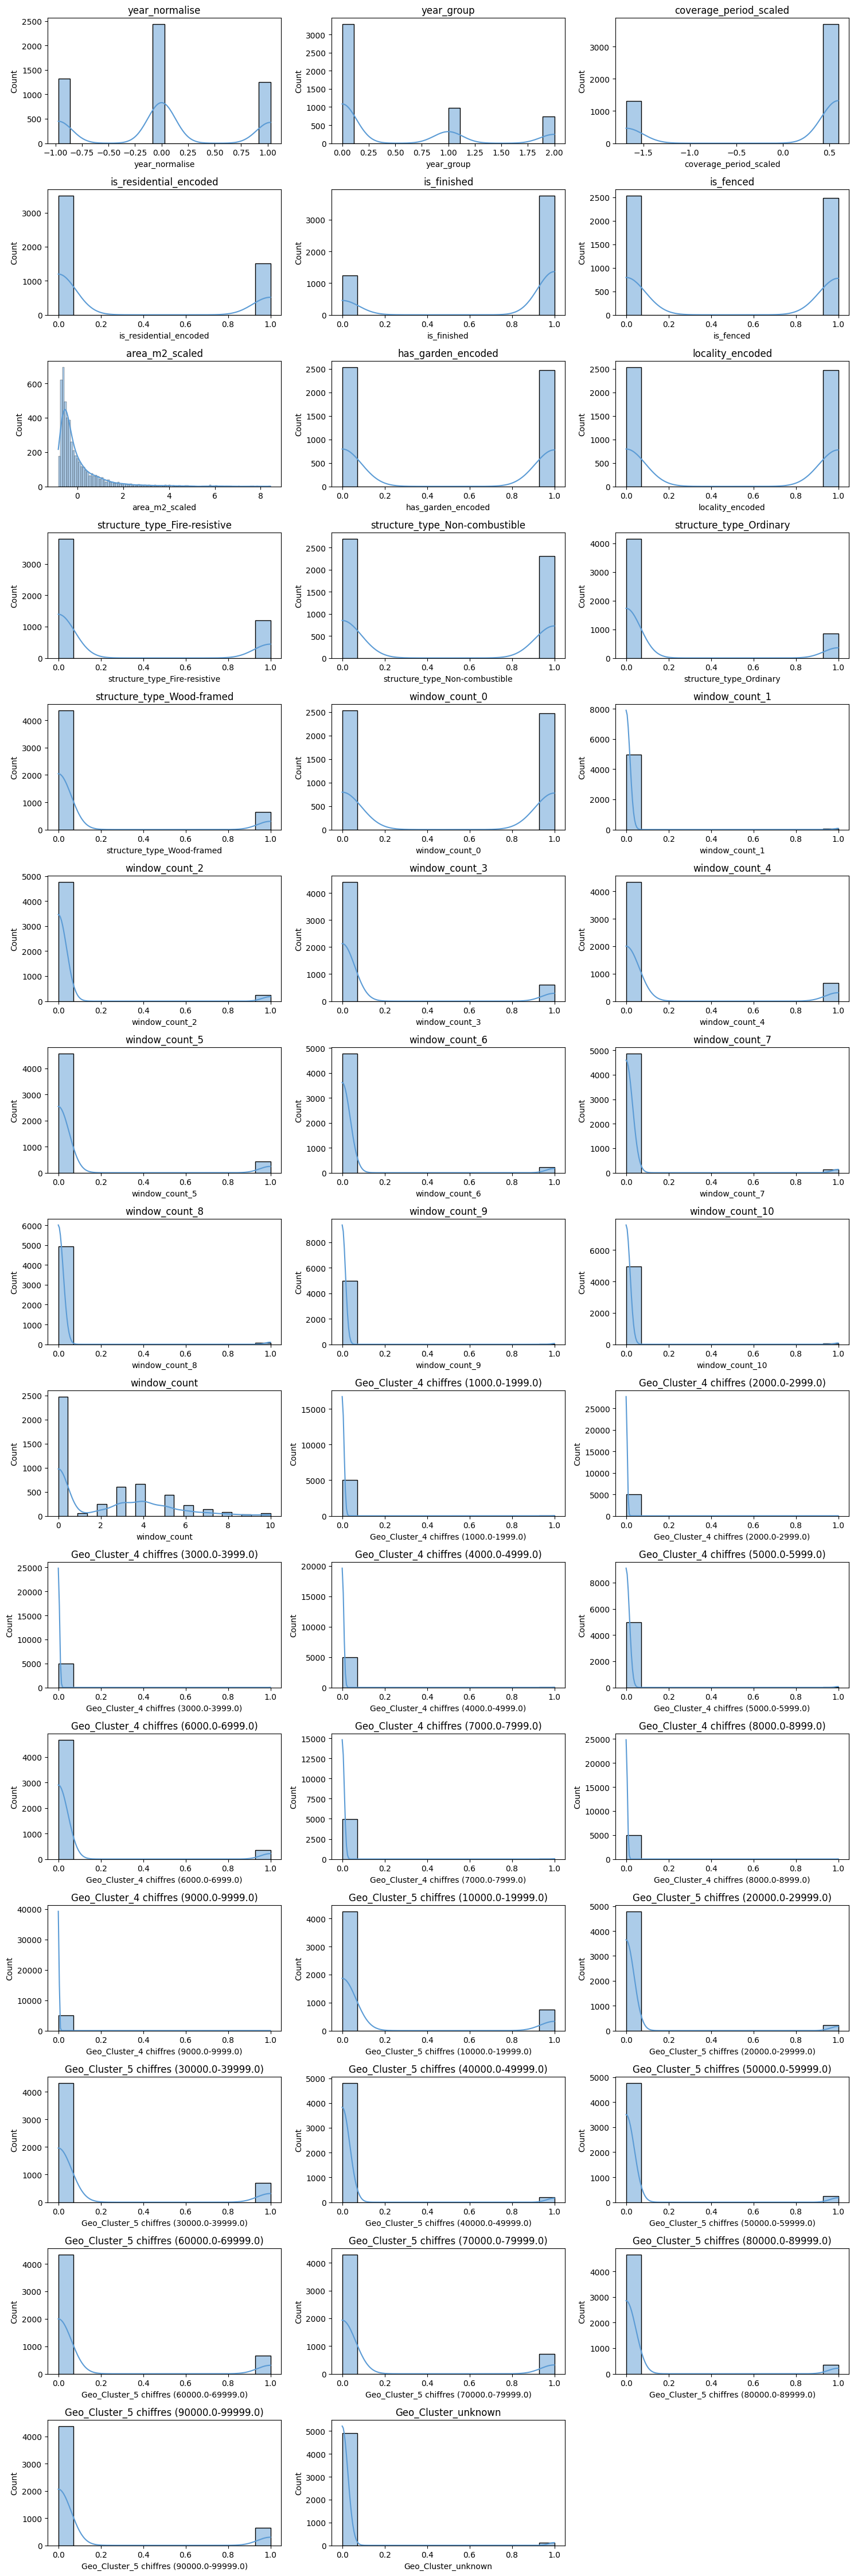

In [20]:
enable_final_plots = True

if enable_final_plots:
    final_numeric = train_df.select_dtypes(include=['int16', 'int32', 'int64', 'float32', 'float64'])
    if final_numeric.empty:
        print("Aucune variable numérique à tracer après les transformations.")
    else:
        n_cols = 3
        n_rows = int(np.ceil(len(final_numeric.columns) / n_cols))
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3 * n_rows))
        axes = axes.flatten()
        for ax, col in zip(axes, final_numeric.columns):
            sns.histplot(final_numeric[col], ax=ax, kde=True, color="#5b9bd5")
            ax.set_title(col)
        for ax in axes[len(final_numeric.columns):]:
            ax.set_visible(False)
        plt.tight_layout()
        plt.show()
else:
    print("Distribution plots désactivés.")

## Jeu de données prêt

In [21]:
if 'claim' in train_df.columns:
    claim_col = train_df.pop('claim')
    train_df['claim'] = claim_col

print(f'Dimension finale: {train_df.shape}')
print(f'Valeurs manquantes restantes: {train_df.isnull().sum().sum()}')
display(train_df.head(30))

Dimension finale: (5012, 45)
Valeurs manquantes restantes: 0


,year_normalise,year_group,coverage_period_scaled,is_residential_encoded,is_finished,is_fenced,area_m2_scaled,has_garden_encoded,locality_encoded,structure_type_Fire-resistive,...,Geo_Cluster_5 chiffres (20000.0-29999.0),Geo_Cluster_5 chiffres (30000.0-39999.0),Geo_Cluster_5 chiffres (40000.0-49999.0),Geo_Cluster_5 chiffres (50000.0-59999.0),Geo_Cluster_5 chiffres (60000.0-69999.0),Geo_Cluster_5 chiffres (70000.0-79999.0),Geo_Cluster_5 chiffres (80000.0-89999.0),Geo_Cluster_5 chiffres (90000.0-99999.0),Geo_Cluster_unknown,claim
0,-0.973902,0,0.593634,1,0,1,-0.277318,1,1,0,...,0,0,0,0,0,1,0,0,0,non
1,-0.973902,0,0.593634,0,0,1,-0.428310,1,1,0,...,0,0,0,0,1,0,0,0,0,non
2,1.026797,0,0.593634,1,1,0,1.385374,0,0,0,...,0,1,0,0,0,0,0,0,0,oui
3,0.000000,0,-1.684539,0,0,1,-0.561539,1,1,0,...,0,0,0,0,0,0,0,0,0,oui
4,-0.973902,0,0.593634,0,0,1,-0.428310,1,1,0,...,0,0,0,1,0,0,0,0,0,non
5,0.000000,0,-1.684539,0,0,1,0.359959,1,1,0,...,0,1,0,0,0,0,0,0,0,non
6,0.000000,1,0.593634,1,1,0,0.282242,0,0,0,...,0,0,0,0,0,1,0,0,0,non
7,0.000000,2,0.593634,0,1,0,0.282242,0,0,0,...,0,1,0,0,0,0,0,0,0,oui
8,1.026797,0,0.593634,0,0,1,-0.526011,1,1,0,...,0,1,0,0,0,0,0,0,0,non
9,1.026797,0,0.593634,0,0,1,-0.559318,1,1,0,...,0,0,0,0,0,0,1,0,0,non


## Détection des valeurs aberrantes 


In [22]:
numeric_columns = (
    train_df
    .drop(columns=['claim'], errors='ignore')
    .select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
 )

iso_forest = IsolationForest(
    contamination=0.02,
    random_state=42,
    n_estimators=300,
    n_jobs=-1
 )
iso_flags = iso_forest.fit_predict(numeric_columns.fillna(0))
train_df['isolation_outlier'] = (iso_flags == -1)

outlier_count = train_df['isolation_outlier'].sum()
print(f"Valeurs aberrantes détectées: {outlier_count} ({outlier_count / len(train_df):.2%})")
print("Répartition cible avant retrait:")
display(train_df['claim'].value_counts())

train_df = train_df.loc[~train_df['isolation_outlier']].reset_index(drop=True)
train_df = train_df.drop(columns=['isolation_outlier'])

print(f"Nouvelle dimension après filtrage: {train_df.shape}")
print("Répartition cible après retrait:")
display(train_df['claim'].value_counts())

Valeurs aberrantes détectées: 101 (2.02%)
Répartition cible avant retrait:


claim
non    3886
oui    1126
Name: count, dtype: int64

Nouvelle dimension après filtrage: (4911, 45)
Répartition cible après retrait:


claim
non    3829
oui    1082
Name: count, dtype: int64

## Préparation  du sheet test


In [23]:
def preprocess_insurance_sheet(df):
    df = df.copy()
    df.dropna(how='all', inplace=True)

    drop_candidates = [col for col in ['risk_score', 'policy_id'] if col in df.columns]
    if drop_candidates:
        df = df.drop(columns=drop_candidates)

    if 'year' in df.columns:
        df = normalize_with_kde(df, 'year')

    if 'coverage_period' in df.columns:
        df = remplace_nan(df, 'coverage_period', strategy='median')
        df = Ajout_col_scaled(df, 'coverage_period')
        df.drop(columns=['coverage_period'], inplace=True)

    if 'is_residential' in df.columns:
        df = remplace_nan(df, 'is_residential', strategy='most_frequent')
        df = numeriser_feature(df, 'is_residential')
        df.drop(columns=['is_residential'], inplace=True)

    if 'is_finished_and_fenced' in df.columns:
        df = decouper_col(df, 'is_finished_and_fenced', ['is_finished', 'is_fenced'])
        df[['is_finished', 'is_fenced']] = df[['is_finished', 'is_fenced']].fillna(0).astype('int32')

    if 'has_garden' in df.columns:
        df = remplace_nan(df, 'has_garden', strategy='most_frequent')
    if 'locality' in df.columns:
        df = remplace_nan(df, 'locality', strategy='most_frequent')

    if 'area_m2' in df.columns:
        df = remplace_nan(df, 'area_m2', strategy='median')
        df = Ajout_col_scaled(df, 'area_m2')

    if 'has_garden' in df.columns:
        df = numeriser_feature(df, 'has_garden')
    if 'locality' in df.columns:
        df = numeriser_feature(df, 'locality')

    extra_drop = [col for col in ['has_garden', 'locality', 'area_m2'] if col in df.columns]
    if extra_drop:
        df = df.drop(columns=extra_drop)

    if 'structure_type' in df.columns:
        df = one_hot_encode_feature(df, 'structure_type')

    if 'window_count' in df.columns:
        df = remplace_nan(df, 'window_count', strategy='most_frequent')
        df['window_count'] = df['window_count'].apply(standardise_window).astype('int32')
        df = one_hot_encode_feature(df, 'window_count')

    if 'Geo_Code' in df.columns:
        df = create_and_encode_geo_code(df)

    final_drop = ['year', 'is_finished_and_fenced', 'Geo_Code']
    df = df.drop(columns=[col for col in final_drop if col in df.columns])

    if 'claim' in df.columns:
        claim_col = df.pop('claim')
        df['claim'] = claim_col

    return df

In [24]:
test_prepared_df = preprocess_insurance_sheet(test_df)
print(f'Dimension test préparé: {test_prepared_df.shape}')
print(f'Valeurs manquantes restantes (test): {test_prepared_df.isnull().sum().sum()}')
if 'claim' in test_prepared_df.columns:
    print("La colonne 'claim' est placée en dernière position")
display(test_prepared_df.head(30))

Dimension test préparé: (2147, 43)
Valeurs manquantes restantes (test): 0
La colonne 'claim' est placée en dernière position


,year_normalise,year_group,coverage_period_scaled,is_residential_encoded,is_finished,is_fenced,area_m2_scaled,has_garden_encoded,locality_encoded,structure_type_Fire-resistive,...,Geo_Cluster_5 chiffres (20000.0-29999.0),Geo_Cluster_5 chiffres (30000.0-39999.0),Geo_Cluster_5 chiffres (40000.0-49999.0),Geo_Cluster_5 chiffres (50000.0-59999.0),Geo_Cluster_5 chiffres (60000.0-69999.0),Geo_Cluster_5 chiffres (70000.0-79999.0),Geo_Cluster_5 chiffres (80000.0-89999.0),Geo_Cluster_5 chiffres (90000.0-99999.0),Geo_Cluster_unknown,claim
0,0.0,1,0.571793,0,1,1,0.817073,1,1,1,...,0,0,1,0,0,0,0,0,0,oui
1,0.0,3,0.571793,0,1,0,-0.190785,0,0,1,...,0,0,0,1,0,0,0,0,0,non
2,0.0,1,0.571793,1,1,0,0.024062,0,0,0,...,0,0,0,0,0,0,0,1,0,oui
3,0.0,3,0.571793,0,0,1,0.166419,1,1,0,...,0,0,0,0,0,0,0,0,0,oui
4,0.0,0,-1.748886,0,1,0,0.474716,0,0,1,...,0,0,0,0,0,0,0,0,0,non
5,0.0,1,0.571793,0,0,1,-0.820478,1,1,0,...,0,0,0,0,0,0,0,0,0,non
6,0.0,0,-1.748886,1,1,0,-0.396898,0,0,0,...,0,0,0,0,0,1,0,0,0,non
7,0.0,1,0.571793,0,1,0,0.549388,0,0,0,...,0,0,0,0,1,0,0,0,0,non
8,0.0,0,-1.748886,0,1,0,-0.519168,0,0,0,...,0,0,0,0,0,1,0,0,0,non
9,0.0,0,0.571793,0,1,1,-0.519168,1,1,0,...,0,0,0,0,0,0,0,0,0,non


**Liste des colonnes**

In [25]:
print (list(train_df))
print (list(test_prepared_df))


['year_normalise', 'year_group', 'coverage_period_scaled', 'is_residential_encoded', 'is_finished', 'is_fenced', 'area_m2_scaled', 'has_garden_encoded', 'locality_encoded', 'structure_type_Fire-resistive', 'structure_type_Non-combustible', 'structure_type_Ordinary', 'structure_type_Wood-framed', 'window_count_0', 'window_count_1', 'window_count_2', 'window_count_3', 'window_count_4', 'window_count_5', 'window_count_6', 'window_count_7', 'window_count_8', 'window_count_9', 'window_count_10', 'window_count', 'Geo_Cluster_4 chiffres (1000.0-1999.0)', 'Geo_Cluster_4 chiffres (2000.0-2999.0)', 'Geo_Cluster_4 chiffres (3000.0-3999.0)', 'Geo_Cluster_4 chiffres (4000.0-4999.0)', 'Geo_Cluster_4 chiffres (5000.0-5999.0)', 'Geo_Cluster_4 chiffres (6000.0-6999.0)', 'Geo_Cluster_4 chiffres (7000.0-7999.0)', 'Geo_Cluster_4 chiffres (8000.0-8999.0)', 'Geo_Cluster_4 chiffres (9000.0-9999.0)', 'Geo_Cluster_5 chiffres (10000.0-19999.0)', 'Geo_Cluster_5 chiffres (20000.0-29999.0)', 'Geo_Cluster_5 chiffre

**Unbalance Data**

In [26]:
train_df['claim'].value_counts().to_frame('count').assign(poutrcentage=lambda x: round((x['count']/x['count'].sum())*100,2))

,count,poutrcentage
claim,,
non,3829,77.97
oui,1082,22.03


### Visualisation du déséquilibre de `claim`

C:\Users\MSI\AppData\Local\Temp\ipykernel_9164\743461365.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=claim_counts, x='label', y='count', palette='Set2', ax=axes[0])


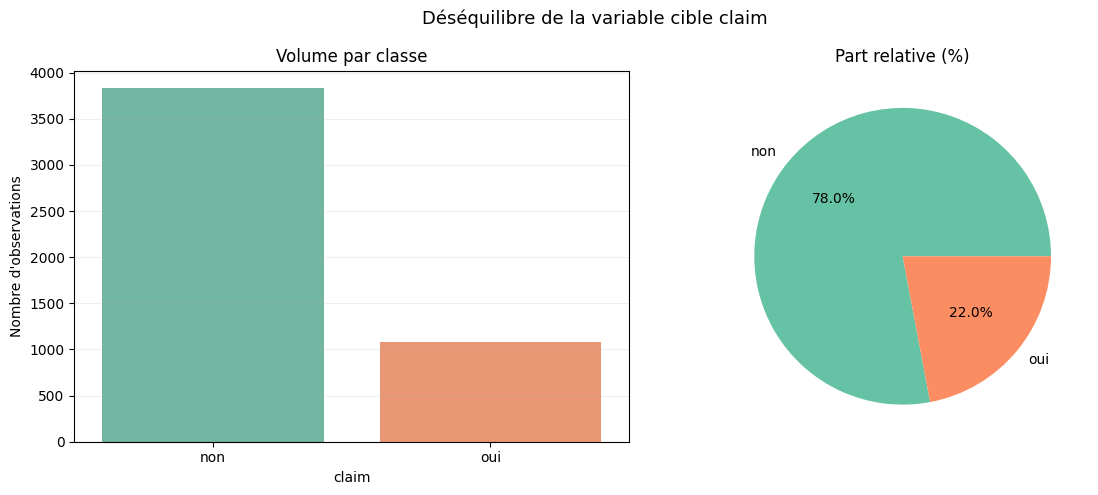

In [27]:
claim_counts = (
    train_df['claim']
        .value_counts()
        .rename_axis('label')
        .reset_index(name='count')
        .assign(pct=lambda df: df['count'] / df['count'].sum() * 100)
 )

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(data=claim_counts, x='label', y='count', palette='Set2', ax=axes[0])
axes[0].set_title('Volume par classe')
axes[0].set_xlabel('claim')
axes[0].set_ylabel('Nombre d\'observations')
axes[0].grid(axis='y', alpha=0.2)

axes[1].pie(
    claim_counts['count'],
    labels=claim_counts['label'],
    autopct=lambda p: f"{p:.1f}%",
    colors=sns.color_palette('Set2', len(claim_counts))
 )
axes[1].set_title('Part relative (%)')

plt.suptitle('Déséquilibre de la variable cible claim', fontsize=13)
plt.tight_layout()
plt.show()

## Préparation par modèle


Répartition des types de features (hors cible):


,count
dtype,
int64,38
float64,3
int32,3


C:\Users\MSI\AppData\Local\Temp\ipykernel_9164\3840737685.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dtype_counts_reset, x='dtype', y='count', palette=palette)


Toutes les colonnes sont numériques ou encodées.
Normalisation spécifique déjà appliquée sur: ['year_normalise', 'coverage_period_scaled', 'area_m2_scaled']
Total features disponibles: 44


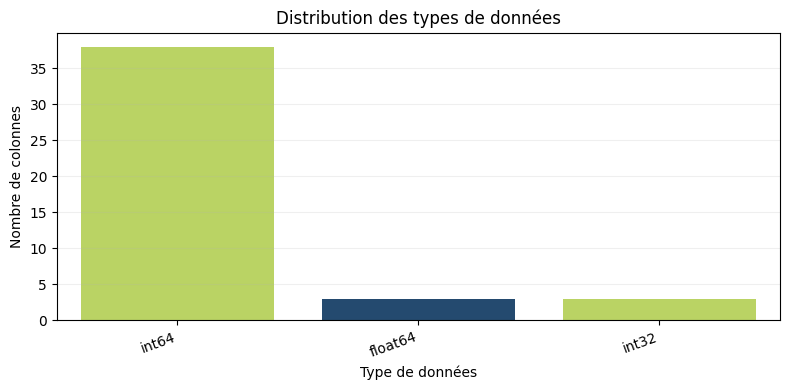

In [28]:
feature_block = train_df.drop(columns=['claim'])
dtype_counts = feature_block.dtypes.value_counts().rename_axis('dtype').to_frame('count')
object_columns = feature_block.select_dtypes(include=['object']).columns.tolist()
print('Répartition des types de features (hors cible):')
display(dtype_counts)
if object_columns:
    print('Colonnes encore non encodées:', object_columns)
else:
    print('Toutes les colonnes sont numériques ou encodées.')

print(f"Normalisation spécifique déjà appliquée sur: {[col for col in train_df.columns if col.endswith(('_scaled', '_normalise'))]}")
print(f"Total features disponibles: {feature_block.shape[1]}")

dtype_counts_reset = (
    dtype_counts
    .reset_index()
    .rename(columns={'index': 'dtype'})
    .sort_values('count', ascending=False)
 )
palette = sns.color_palette(['#c4e551', '#174a7c'], n_colors=len(dtype_counts_reset))
plt.figure(figsize=(8, 4))
sns.barplot(data=dtype_counts_reset, x='dtype', y='count', palette=palette)
plt.title('Distribution des types de données')
plt.xlabel('Type de données')
plt.ylabel('Nombre de colonnes')
plt.xticks(rotation=20, ha='right')
plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()

### Gestion du déséquilibre de classes
La cible `claim` reste fortement déséquilibrée. Avant d'entraîner les modèles, on applique une approche hybride aléatoire

In [29]:
counts = train_df['claim'].value_counts()
minor, major = counts.idxmin(), counts.idxmax()

minority = resample(
    train_df[train_df['claim'] == minor],
    replace=True,
    n_samples=counts[major],
    random_state=42
)
majority = resample(
    train_df[train_df['claim'] == major],
    replace=False,
    n_samples=counts[major],
    random_state=42
)

train_balanced_df = pd.concat([majority, minority]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Répartition avant équilibrage:", counts.to_dict())
print("Répartition après équilibrage:", train_balanced_df['claim'].value_counts().to_dict())

feature_cols = [col for col in train_balanced_df.columns if col != 'claim']
X_balanced = train_balanced_df[feature_cols]
y_balanced = train_balanced_df['claim']
print(f"Taille du dataset équilibré: {train_balanced_df.shape}")
print(f"Nombre de features pour l'entraînement: {len(feature_cols)}")

Répartition avant équilibrage: {'non': 3829, 'oui': 1082}
Répartition après équilibrage: {'oui': 3829, 'non': 3829}
Taille du dataset équilibré: (7658, 45)
Nombre de features pour l'entraînement: 44


## Modélisation supervisée


In [30]:
test_size = 0.3
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced,
    y_balanced,
    test_size=test_size,
    random_state=random_state,
    stratify=y_balanced
)

print(f"X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"X_test: {X_test.shape} | y_test: {y_test.shape}")

positive_label = 'oui' if 'oui' in y_train.unique() else y_train.unique()[0]
print(f"Libellé positif utilisé pour les métriques: {positive_label}")

X_train: (5360, 44) | y_train: (5360,)
X_test: (2298, 44) | y_test: (2298,)
Libellé positif utilisé pour les métriques: oui


In [31]:
def compute_classification_metrics(y_true, y_pred, y_score=None, positive_label='oui'):
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred, index=y_true.index)
    y_true_bin = (y_true == positive_label).astype(int)
    y_pred_bin = (y_pred == positive_label).astype(int)

    metrics = {}
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['error_rate'] = 1 - metrics['accuracy']
    metrics['precision'] = precision_score(y_true, y_pred, pos_label=positive_label, zero_division=0)
    metrics['recall'] = recall_score(y_true, y_pred, pos_label=positive_label, zero_division=0)
    metrics['f1'] = f1_score(y_true, y_pred, pos_label=positive_label, zero_division=0)
    metrics['f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['f1_weighted'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    metrics['mae'] = mean_absolute_error(y_true_bin, y_pred_bin)
    metrics['mse'] = mean_squared_error(y_true_bin, y_pred_bin)
    metrics['r2'] = r2_score(y_true_bin, y_pred_bin)

    if y_score is not None:
        try:
            metrics['roc_auc'] = roc_auc_score(y_true_bin, y_score)
        except ValueError:
            metrics['roc_auc'] = np.nan
    else:
        metrics['roc_auc'] = np.nan

    return metrics


def generalization_check(train_score, test_score, tolerance=0.05, high_bar=0.85):
    if pd.isna(train_score) or pd.isna(test_score):
        return 'insufficient data'
    if train_score - test_score > tolerance:
        return 'possible overfitting'
    if test_score - train_score > tolerance:
        return 'possible underfitting'
    if train_score >= high_bar and test_score >= high_bar:
        return 'high & balanced (good fit)'
    return 'balanced'

In [32]:
def evaluate_model(name, model):
    """Entraîne un modèle et retourne les métriques train/test + prédictions."""
    model.fit(X_train, y_train)
    split_metrics = []
    split_predictions = {}
    splits = {
        'train': (X_train, y_train),
        'test': (X_test, y_test)
    }

    for split_name, (X_split, y_split) in splits.items():
        y_pred = model.predict(X_split)
        if hasattr(model, 'predict_proba'):
            classes = list(model.classes_)
            pos_index = classes.index(positive_label) if positive_label in classes else -1
            y_score = model.predict_proba(X_split)[:, pos_index]
        elif hasattr(model, 'decision_function'):
            raw_score = model.decision_function(X_split)
            if isinstance(raw_score, np.ndarray) and raw_score.ndim > 1:
                classes = list(model.classes_)
                pos_index = classes.index(positive_label) if positive_label in classes else -1
                y_score = raw_score[:, pos_index]
            else:
                y_score = raw_score
        else:
            y_score = None

        metrics = compute_classification_metrics(y_split, y_pred, y_score, positive_label=positive_label)
        metrics['model'] = name
        metrics['split'] = split_name
        split_metrics.append(metrics)

        split_predictions[split_name] = {
            'y_true': y_split,
            'y_pred': y_pred,
            'y_score': y_score
        }

    return split_metrics, split_predictions



core_models = [
    ("LogisticRegression", LogisticRegression(class_weight='balanced', max_iter=300, random_state=random_state)),
    ("DecisionTree", DecisionTreeClassifier(class_weight='balanced', random_state=random_state)),
    ("RandomForest", RandomForestClassifier(n_estimators=400, class_weight='balanced', bootstrap=True, random_state=random_state, n_jobs=-1)),
    ("GradientBoosting", GradientBoostingClassifier(random_state=random_state)),
    ("SVC_rbf", SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=random_state)),
    ("KNN", KNeighborsClassifier(n_neighbors=15, weights='distance'))
 ]

baseline_models = core_models

all_results = []
predictions = {}
for name, model in baseline_models:
    metrics, splits_pred = evaluate_model(name, model)
    all_results.extend(metrics)
    predictions[name] = splits_pred

# Voting meta-modèle (soft) qui agrège les six apprenants de base
voting_estimators = [(name, clone(model)) for name, model in core_models]
voting_clf = VotingClassifier(
    estimators=voting_estimators,
    voting='soft',
    n_jobs=-1
 )
voting_metrics, voting_preds = evaluate_model("VotingClassifier", voting_clf)
all_results.extend(voting_metrics)
predictions["VotingClassifier"] = voting_preds

all_results_df = pd.DataFrame(all_results)
metric_cols = [
    'accuracy', 'error_rate', 'precision', 'recall', 'f1', 'f1_macro', 'f1_weighted', 'roc_auc', 'mae', 'mse', 'r2'
 ]
wide_df = (
    all_results_df
        .set_index(['model', 'split'])[metric_cols]
        .unstack('split')
 )
wide_df.columns = [f"{metric}_{split}" for metric, split in wide_df.columns]
wide_df = wide_df.reset_index().sort_values(by='f1_test', ascending=False)

display(wide_df)

,model,accuracy_test,accuracy_train,error_rate_test,error_rate_train,precision_test,precision_train,recall_test,recall_train,f1_test,...,f1_weighted_test,f1_weighted_train,roc_auc_test,roc_auc_train,mae_test,mae_train,mse_test,mse_train,r2_test,r2_train
4,RandomForest,0.873803,0.994030,0.126197,0.005970,0.826616,0.991098,0.946040,0.997015,0.882305,...,0.873141,0.994030,0.945295,0.999674,0.126197,0.005970,0.126197,0.005970,0.495213,0.976119
6,VotingClassifier,0.859878,0.993657,0.140122,0.006343,0.803821,0.991822,0.952132,0.995522,0.871713,...,0.858675,0.993657,0.931760,0.999623,0.140122,0.006343,0.140122,0.006343,0.439513,0.974627
0,DecisionTree,0.844212,0.994030,0.155788,0.005970,0.787219,0.991828,0.943429,0.996269,0.858274,...,0.842664,0.994030,0.848142,0.999891,0.155788,0.005970,0.155788,0.005970,0.376849,0.976119
2,KNN,0.816362,0.994030,0.183638,0.005970,0.750517,0.991828,0.947781,0.996269,0.837692,...,0.813135,0.994030,0.959295,0.999891,0.183638,0.005970,0.183638,0.005970,0.265448,0.976119
1,GradientBoosting,0.675805,0.695149,0.324195,0.304851,0.685662,0.710209,0.649260,0.659328,0.666965,...,0.675576,0.694758,0.748672,0.775584,0.324195,0.304851,0.324195,0.304851,-0.296780,-0.219403
5,SVC_rbf,0.671889,0.676493,0.328111,0.323507,0.686850,0.697412,0.631854,0.623507,0.658205,...,0.671362,0.675582,0.736419,0.752284,0.328111,0.323507,0.328111,0.323507,-0.312446,-0.294030
3,LogisticRegression,0.652742,0.645522,0.347258,0.354478,0.678899,0.675676,0.579634,0.559701,0.625352,...,0.650876,0.642892,0.718029,0.709180,0.347258,0.354478,0.347258,0.354478,-0.389034,-0.417910


### Courbe F1 (train vs test)


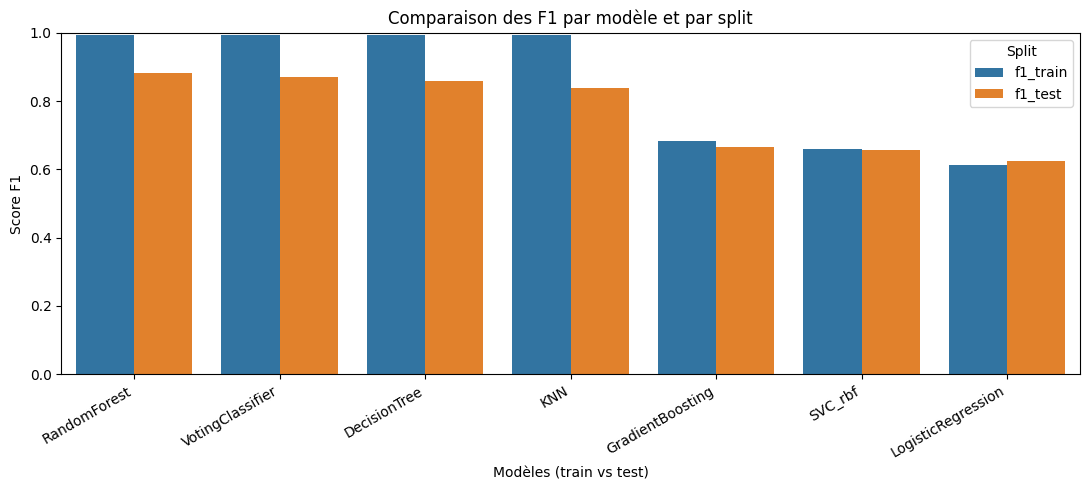

In [33]:
plot_source = wide_df[['model', 'f1_train', 'f1_test']].copy()
plot_source = plot_source.melt(
    id_vars='model',
    value_vars=['f1_train', 'f1_test'],
    var_name='split',
    value_name='f1_score'
 )
plot_source['model'] = pd.Categorical(plot_source['model'], categories=wide_df['model'], ordered=True)

plt.figure(figsize=(11, 5))
sns.barplot(
    data=plot_source,
    x='model',
    y='f1_score',
    hue='split'
)
plt.ylim(0, 1)
plt.xlabel('Modèles (train vs test)')
plt.ylabel('Score F1')
plt.title('Comparaison des F1 par modèle et par split')
plt.xticks(rotation=30, ha='right')
plt.legend(title='Split')
plt.tight_layout()
plt.show()

In [34]:
generalization_rows = []
for _, row in wide_df.iterrows():
    train_f1 = row.get('f1_train', np.nan)
    test_f1 = row.get('f1_test', np.nan)
    generalization_rows.append({
        'model': row['model'],
        'f1_train': train_f1,
        'f1_test': test_f1,
        'diagnosis': generalization_check(train_f1, test_f1)
    })
generalization_df = pd.DataFrame(generalization_rows).sort_values(by='f1_test', ascending=False)
display(generalization_df)

best_model_name = generalization_df.iloc[0]['model']
print(f"Meilleur modèle selon F1 test: {best_model_name}")

,model,f1_train,f1_test,diagnosis
0,RandomForest,0.994048,0.882305,possible overfitting
1,VotingClassifier,0.993669,0.871713,possible overfitting
2,DecisionTree,0.994043,0.858274,possible overfitting
3,KNN,0.994043,0.837692,possible overfitting
4,GradientBoosting,0.683824,0.666965,balanced
5,SVC_rbf,0.658392,0.658205,balanced
6,LogisticRegression,0.612245,0.625352,balanced


Meilleur modèle selon F1 test: RandomForest


In [35]:
best_test = predictions[best_model_name]['test']
best_train = predictions[best_model_name]['train']

cm_test = confusion_matrix(best_test['y_true'], best_test['y_pred'])
cm_train = confusion_matrix(best_train['y_true'], best_train['y_pred'])

print(f"Meilleur modèle (selon F1 test): {best_model_name}")
print("Matrice de confusion - TEST (30%):")
cm_test_df = pd.DataFrame(cm_test, index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1'])
display(cm_test_df)

print("Matrice de confusion - TRAIN (70%):")
cm_train_df = pd.DataFrame(cm_train, index=['Actual 0', 'Actual 1'], columns=['Pred 0', 'Pred 1'])
display(cm_train_df)

Meilleur modèle (selon F1 test): RandomForest
Matrice de confusion - TEST (30%):


,Pred 0,Pred 1
Actual 0,921,228
Actual 1,62,1087


Matrice de confusion - TRAIN (70%):


,Pred 0,Pred 1
Actual 0,2656,24
Actual 1,8,2672


### Visualisations dédiées au DecisionTreeClassifier


Top 15 features selon CART:


,importance
area_m2_scaled,0.521939
year_normalise,0.054607
window_count,0.045538
year_group,0.037377
Geo_Cluster_5 chiffres (70000.0-79999.0),0.027064
is_residential_encoded,0.026290
structure_type_Ordinary,0.022038
is_finished,0.020985
structure_type_Non-combustible,0.019407
structure_type_Wood-framed,0.019141


C:\Users\MSI\AppData\Local\Temp\ipykernel_9164\3763471623.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


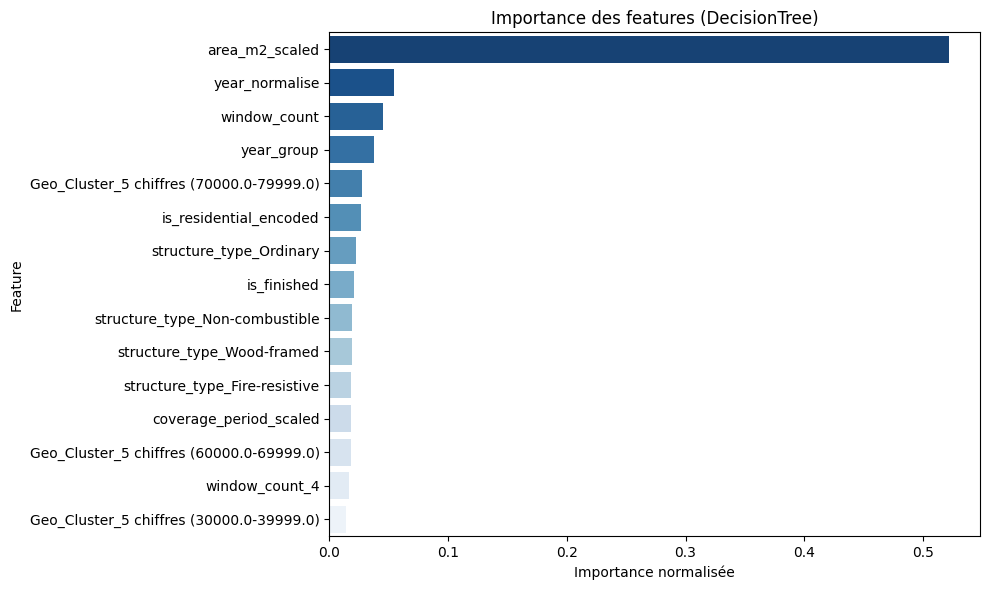

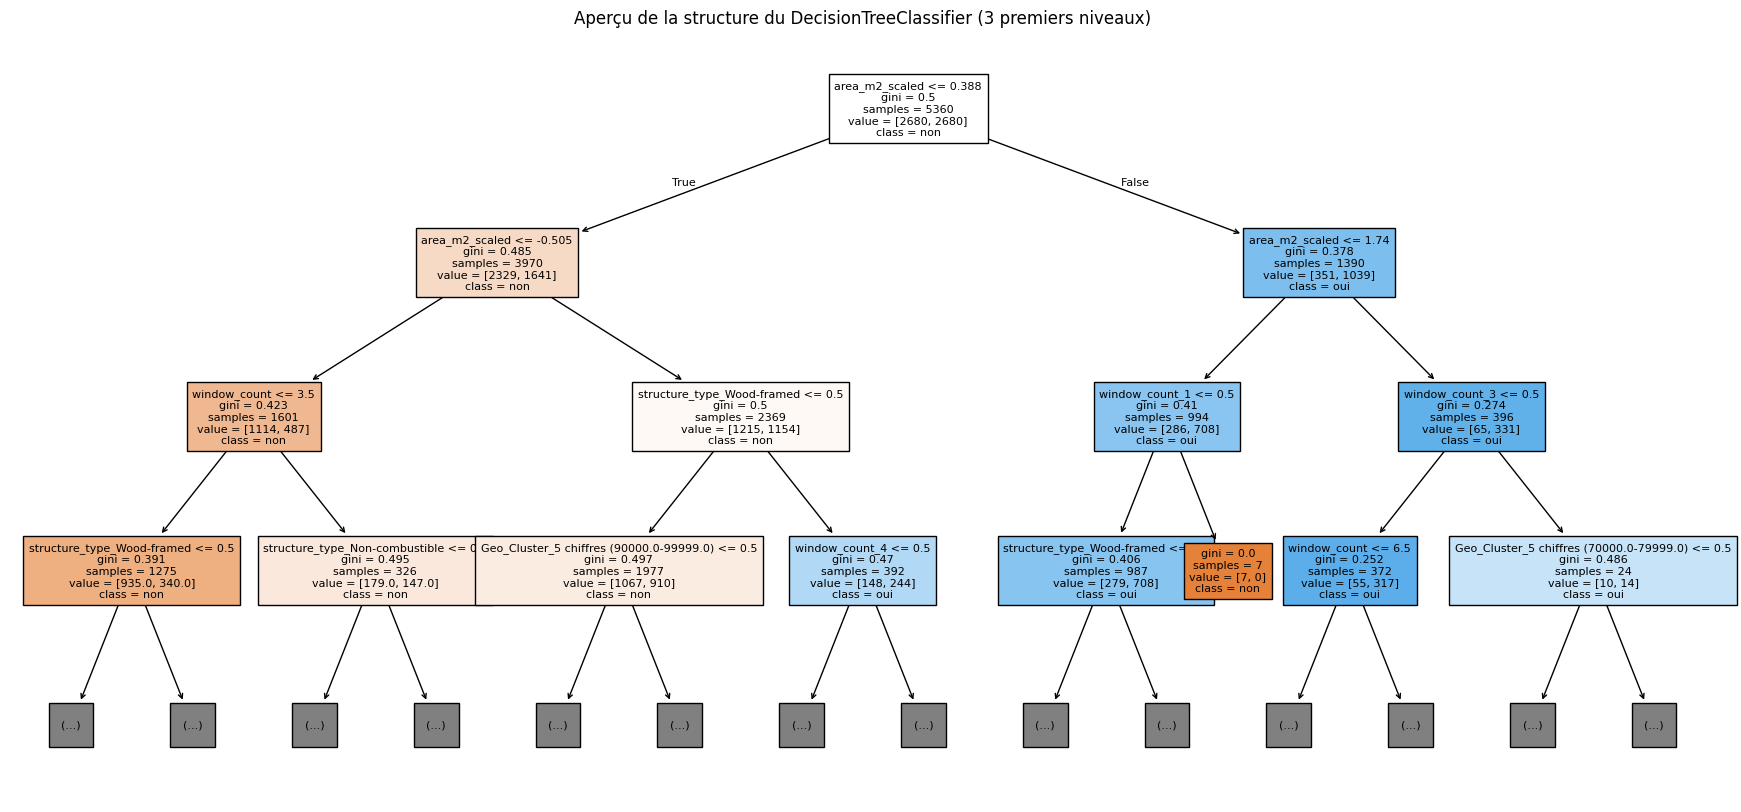

In [36]:
dt_viz_model = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=random_state,
    min_samples_leaf=5
)
dt_viz_model.fit(X_train, y_train)

importance_series = (
    pd.Series(dt_viz_model.feature_importances_, index=X_train.columns)
      .sort_values(ascending=False)
)
top_k_dt = 15
top_dt = importance_series.head(top_k_dt).to_frame('importance')
print(f"Top {top_k_dt} features selon CART:")
display(top_dt)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_dt.reset_index().rename(columns={'index': 'feature'}),
    x='importance',
    y='feature',
    palette='Blues_r'
 )
plt.title('Importance des features (DecisionTree)')
plt.xlabel('Importance normalisée')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

plt.figure(figsize=(22, 10))
plot_tree(
    dt_viz_model,
    feature_names=X_train.columns,
    class_names=[str(cls) for cls in dt_viz_model.classes_],
    filled=True,
    max_depth=3,
    fontsize=8
)
plt.title('Aperçu de la structure du DecisionTreeClassifier (3 premiers niveaux)')
plt.show()

### Recherche d'hyperparamètres (RandomForest)
Deux stratégies sont proposées :


In [37]:
def oob_scorer(estimator, X, y):
    return getattr(estimator, 'oob_score_', np.nan)

rf_base = RandomForestClassifier(
    class_weight='balanced',
    bootstrap=True,
    oob_score=True,
    random_state=random_state,
    n_jobs=-1
)

grid_params = {
    'n_estimators': [200, 400, 600],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1, 5, 10],
    'max_samples': [0.63, None]
}

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=grid_params,
    scoring=oob_scorer,
    cv=5,
    n_jobs=-1,
    refit=True
)
grid_search.fit(X_train, y_train)
grid_results = (
    pd.DataFrame(grid_search.cv_results_)[['params', 'mean_test_score']]
    .sort_values(by='mean_test_score', ascending=False)
)
print("Top configurations (GridSearchCV - score OOB):")
display(grid_results.head(5))

best_grid_estimator = grid_search.best_estimator_
print("Meilleur estimateur (GridSearchCV) et score OOB (refit):")
print(grid_search.best_params_)
print(f"OOB score refit: {getattr(best_grid_estimator, 'oob_score_', np.nan):.3f}")

f1_scorer = make_scorer(f1_score, pos_label=positive_label, zero_division=0)
rf_random = RandomForestClassifier(
    class_weight='balanced',
    bootstrap=True,
    oob_score=True,
    random_state=random_state,
    n_jobs=-1
)
random_params = {
    'n_estimators': [150, 200, 300, 400, 500],
    'max_depth': [None, 8, 12, 16, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator=rf_random,
    param_distributions=random_params,
    n_iter=10,
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1,
    random_state=random_state,
    refit=True
)
random_search.fit(X_train, y_train)
print("Meilleurs hyperparamètres (RandomizedSearchCV - F1):")
print(random_search.best_params_)
print(f"Score moyen CV (F1): {random_search.best_score_:.3f}")

best_random_estimator = random_search.best_estimator_
print(f"OOB score du meilleur estimateur RandomizedSearchCV: {getattr(best_random_estimator, 'oob_score_', np.nan):.3f}")

KeyboardInterrupt: 

### Sélection des meilleures features & réentraînement


In [ ]:
feature_source_label = None
if 'best_random_estimator' in globals():
    feature_source_model = best_random_estimator
    feature_source_label = 'RandomizedSearchCV'
elif 'best_grid_estimator' in globals():
    feature_source_model = best_grid_estimator
    feature_source_label = 'GridSearchCV'
else:
    feature_source_model = RandomForestClassifier(
        n_estimators=400,
        class_weight='balanced',
        bootstrap=True,
        random_state=random_state,
        n_jobs=-1
    )
    feature_source_model.fit(X_train, y_train)
    feature_source_label = 'RandomForest (baseline)'

print(f"Importance des features derivée de: {feature_source_label}")
feature_importances = pd.Series(
    feature_source_model.feature_importances_,
    index=X_train.columns
 ).sort_values(ascending=False)

feature_importances_df = feature_importances.to_frame('importance')
feature_importances_df['cumulative_importance'] = feature_importances_df['importance'].cumsum()
top_k_features = 20
top_features = feature_importances_df.head(top_k_features).index.tolist()
print(f"Top {top_k_features} features retenues:")
display(feature_importances_df.head(top_k_features))

subset_splits = {
    'train': (X_train[top_features], y_train),
    'test': (X_test[top_features], y_test)
}

focused_results = []
subset_predictions = {}
for name, base_model in core_models:
    subset_model = clone(base_model)
    subset_model.fit(subset_splits['train'][0], subset_splits['train'][1])
    subset_predictions[name] = {}
    for split_name, (X_subset, y_subset) in subset_splits.items():
        y_pred_subset = subset_model.predict(X_subset)
        if hasattr(subset_model, 'predict_proba'):
            classes = list(subset_model.classes_)
            pos_idx = classes.index(positive_label) if positive_label in classes else -1
            y_score_subset = subset_model.predict_proba(X_subset)[:, pos_idx]
        elif hasattr(subset_model, 'decision_function'):
            raw_score_subset = subset_model.decision_function(X_subset)
            if isinstance(raw_score_subset, np.ndarray) and raw_score_subset.ndim > 1:
                classes = list(subset_model.classes_)
                pos_idx = classes.index(positive_label) if positive_label in classes else -1
                y_score_subset = raw_score_subset[:, pos_idx]
            else:
                y_score_subset = raw_score_subset
        else:
            y_score_subset = None

        metrics_subset = compute_classification_metrics(
            y_subset,
            y_pred_subset,
            y_score_subset,
            positive_label=positive_label
        )
        metrics_subset['split'] = split_name
        metrics_subset['model'] = name
        focused_results.append(metrics_subset)
        subset_predictions[name][split_name] = {
            'y_true': y_subset,
            'y_pred': y_pred_subset,
            'y_score': y_score_subset
        }

voting_subset = VotingClassifier(
    estimators=[(name, clone(model)) for name, model in core_models],
    voting='soft',
    n_jobs=-1
 )
voting_subset.fit(subset_splits['train'][0], subset_splits['train'][1])
subset_predictions['VotingClassifier'] = {}
for split_name, (X_subset, y_subset) in subset_splits.items():
    y_pred_subset = voting_subset.predict(X_subset)
    classes = list(voting_subset.classes_)
    pos_idx = classes.index(positive_label) if positive_label in classes else -1
    y_score_subset = voting_subset.predict_proba(X_subset)[:, pos_idx]
    metrics_subset = compute_classification_metrics(
        y_subset,
        y_pred_subset,
        y_score_subset,
        positive_label=positive_label
    )
    metrics_subset['split'] = split_name
    metrics_subset['model'] = 'VotingClassifier'
    focused_results.append(metrics_subset)
    subset_predictions['VotingClassifier'][split_name] = {
        'y_true': y_subset,
        'y_pred': y_pred_subset,
        'y_score': y_score_subset
    }

focused_results_df = pd.DataFrame(focused_results)
print("Métriques après réentraînement limité aux meilleures features:")
display(focused_results_df[['model', 'split', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']])

Importance des features derivée de: RandomizedSearchCV
Top 20 features retenues:


,importance,cumulative_importance
area_m2_scaled,0.446553,0.446553
year_normalise,0.068916,0.515469
year_group,0.055289,0.570758
window_count,0.044006,0.614764
coverage_period_scaled,0.037497,0.652261
is_residential_encoded,0.036153,0.688415
is_finished,0.021860,0.710275
structure_type_Non-combustible,0.019977,0.730251
Geo_Cluster_5 chiffres (30000.0-39999.0),0.019235,0.749486
structure_type_Fire-resistive,0.018897,0.768383


Métriques après réentraînement limité aux meilleures features:


,model,split,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression,train,0.640299,0.671376,0.549627,0.604432,0.699795
1,LogisticRegression,test,0.652306,0.681159,0.572672,0.622222,0.712817
2,DecisionTree,train,0.994030,0.991828,0.996269,0.994043,0.999891
3,DecisionTree,test,0.842472,0.784116,0.945170,0.857143,0.845906
4,RandomForest,train,0.994030,0.990734,0.997388,0.994050,0.999677
5,RandomForest,test,0.870757,0.823708,0.943429,0.879513,0.949833
6,GradientBoosting,train,0.694776,0.717681,0.642164,0.677826,0.778130
7,GradientBoosting,test,0.678416,0.690167,0.647520,0.668163,0.750288
8,SVC_rbf,train,0.673134,0.691577,0.625000,0.656605,0.749299
9,SVC_rbf,test,0.665361,0.676252,0.634465,0.654692,0.736523


### Courbes ROC (features sélectionnées)
Comparaison des mêmes modèles (et du VotingClassifier) mais réentraînés uniquement sur les 20 meilleures variables

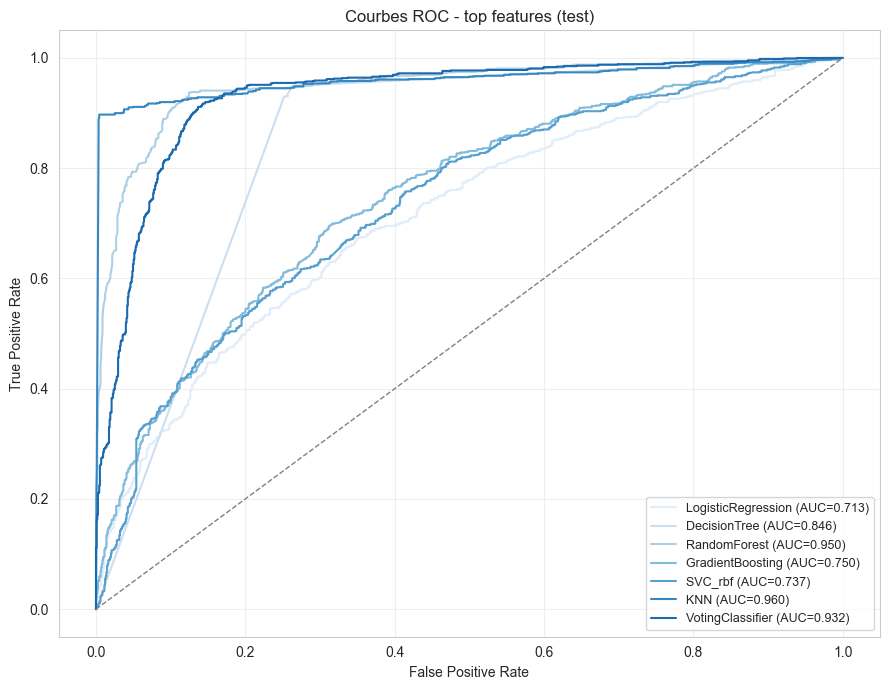

In [ ]:
plt.figure(figsize=(9, 7))
for model_name, splits in subset_predictions.items():
    test_payload = splits.get('test', {})
    y_true = test_payload.get('y_true')
    y_score = test_payload.get('y_score')
    if y_true is None or y_score is None:
        continue
    y_true_bin = (pd.Series(y_true).values == positive_label).astype(int)
    fpr, tpr, _ = roc_curve(y_true_bin, y_score)
    auc_value = roc_auc_score(y_true_bin, y_score)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc_value:.3f})")

plt.plot([0, 1], [0, 1], '--', color='gray', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbes ROC - top features (test)')
plt.legend(loc='lower right', fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()